# Semesterarbeit Teil 4

### Teil 4

# Einführung
- Die beiden Dateien client_trace50 und mw_trace50 sind beide auf dem HDFS. Aufgrund der vorangegangenen Nachbearbeitungen muss die Datei client_trace50 auf HDFS getan werden, mw_trace50 ist bereits dort vorhanden.<br>

- Das Kennenlernen und die Bereinigung der Daten von mw_trace50 ist aus den vorangegangenen Nachbearbeitung bereits getan, dies wird nun auch für client_trace50 angewendet. Die Resultate aus beiden Dateien werden hier erwähnt. **Auf das Kennenlernen der Daten aus mw_trace50 wird nicht intensiv eingegangen, weil es sich dabei um eine Wiederholung von den vorangegangenen Nachbearbeitung handelt. Es kommen eher neue Informationen dazu.**<br>

- Für die Analyse wird Spark DataFrames verwendet.

- Die etwas komplexere Datenanalyse folgt nach der Datenbereinigung und dem Kennenlernen der Daten.

<br>

Somit ist die Vorgehensweise:
- Daten lesen
- Datenbereingung und Kennenlernen von Daten in mw_trace50 **nicht jede Spalte aufgrund vorangegangener Nachbearbeitung**
- Datenbereingung und Kennenlernen von Daten in client_trace50  **jede Spalte**
- Weiteres Kennenlernen der Daten **Hauptinhalt**
- Beantwortung der weiteren Fragen **Hauptinhalt**<br>

**Vorgehensweise im Hauptinhalt:**<br>
Pro Request/Response Paar die Antwortzeit berechnen anhand loc_ts am Beispiel vom client_id=1 als Demo<br>
Dies für alle Clients wiederholen<br>
Alle Clients darstellen und den Client 5 darstellen<br>
Dies für den Server wiederholen<br>
Timestamp ansehen<br>
Schwächen der Analyse erwähnen<br>

In [108]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, when, sum, count, countDistinct, min, max, variance, var_pop, stddev, stddev_pop
from pyspark.sql.functions import from_unixtime, to_timestamp, to_date
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType, FloatType

In [109]:
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .master("spark://localhost:7077") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.files.ignoreMissingFiles", "true")
sc = spark.sparkContext

In [110]:
dfc = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs:///user/tirsus/client_trace50.csv")

In [111]:
dfs = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs:///user/tirsus/mw_trace50.csv")

# Datenbereingung und Kennenlernen von mw_trace50
Die Datenberinigung beinhaltet die Überprüfung von 0 Werten und Null Werten pro Spalte. Ebenfalls das Hinzufügen von einer neuen Spalte, die den leserlichen Timestamp enthält. Die Typen der Spalten sollen ebenfalls überprüft werden. Es muss weder imputiert, normalisiert oder standardisiert werden.

Schema ansehen

In [112]:
dfs.printSchema()
dfs.show()

root
 |-- id: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- loc_ts: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- op: string (nullable = true)
 |-- err_code: string (nullable = true)
 |-- time: double (nullable = true)
 |-- thread_id: integer (nullable = true)

+---+-------+---------+------+------+-----------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|         op|err_code|      time|thread_id|
+---+-------+---------+------+------+-----------+--------+----------+---------+
|  1|msg_arr|        0|     1|    43|  enrol_req|      -1|1.41425E12|       14|
|  2|msg_enq|        0|     1|    43|  enrol_req|      -1|1.41425E12|       14|
|  3|msg_deq|        0|     1|     0|  enrol_req|      -1|1.41425E12|       10|
|  4|ta_exec|        0|     1|     0|  enrol_req|      -1|1.41425E12|       10|
|  5|res_snd|        0|     1|     0| enrol_resp|    null|1.41425E12|       10|
|  6|msg_ar

Schema anpassen, err_code soll Integer Werte enthalten. Ohne Anpassung bleibt es ein String.

In [113]:
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("code", StringType(), True),
    StructField("client_id", IntegerType(), True),
    StructField("loc_ts", IntegerType(), True),
    StructField("length", IntegerType(), True),
    StructField("op", StringType(), True),
    StructField("err_code", IntegerType(), True),
    StructField("time", DoubleType(), True),
    StructField("thread_id", IntegerType(), True)
])

Das Schema schema wird nun verwendet, die Daten erneut eingelesen.

In [114]:
dfs = spark.read.option("header", "true").schema(schema).csv("hdfs:///user/tirsus/mw_trace50.csv")
dfs.printSchema()
dfs.show()

root
 |-- id: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- loc_ts: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- op: string (nullable = true)
 |-- err_code: integer (nullable = true)
 |-- time: double (nullable = true)
 |-- thread_id: integer (nullable = true)

+---+-------+---------+------+------+-----------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|         op|err_code|      time|thread_id|
+---+-------+---------+------+------+-----------+--------+----------+---------+
|  1|msg_arr|        0|     1|    43|  enrol_req|      -1|1.41425E12|       14|
|  2|msg_enq|        0|     1|    43|  enrol_req|      -1|1.41425E12|       14|
|  3|msg_deq|        0|     1|     0|  enrol_req|      -1|1.41425E12|       10|
|  4|ta_exec|        0|     1|     0|  enrol_req|      -1|1.41425E12|       10|
|  5|res_snd|        0|     1|     0| enrol_resp|    NULL|1.41425E12|       10|
|  6|msg_a

Bei client_id sollen die 0 dann entfernt werden.

In [115]:
dfs = dfs.filter(col("client_id") != 0)

In [116]:
dfs.filter(col("client_id") == 0).groupBy("client_id").count().show()

+---------+-----+
|client_id|count|
+---------+-----+
+---------+-----+



Nullwerte oder 0 Werte erkennen. Bei client_id sollen die 0 dann entfernt werden.

In [117]:
print(dfs.filter((col("id") == 0) | (col("id").isNull())).count() > 0)
print(dfs.filter((col("code") == 0) | (col("code").isNull())).count() > 0)
print(dfs.filter((col("client_id").isNull())).count() > 0)
print(dfs.filter((col("loc_ts") == 0) | (col("loc_ts").isNull())).count() > 0)
print(dfs.filter((col("length").isNull())).count() > 0)
print(dfs.filter((col("op") == 0) | (col("op").isNull())).count() > 0)
print(dfs.filter((col("err_code").isNull())).count() > 0)
print(dfs.filter((col("time") == 0) | (col("time").isNull())).count() > 0)
print(dfs.filter((col("thread_id") == 0) | (col("thread_id").isNull())).count() > 0)

False


False


False


False


False


False


True


False


False


err_code Null Werte zählen und in Vergleich zu allen Zeilen.

In [118]:
print(dfs.filter((col("err_code").isNull())).count())
dfs.count()

120152


1048510

In [119]:
dfs.filter(col("err_code").isNull()).show(10)

+---+-------+---------+------+------+----------------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|              op|err_code|      time|thread_id|
+---+-------+---------+------+------+----------------+--------+----------+---------+
| 30|res_snd|        1|    27|     0|   queue_created|    NULL|1.41425E12|       12|
| 36|res_snd|        1|    28|     0|    message_sent|    NULL|1.41425E12|       10|
| 41|res_snd|        1|    29|     0|         pop_res|    NULL|1.41425E12|       11|
| 97|res_snd|        1|    40|     0|    message_sent|    NULL|1.41425E12|       10|
|102|res_snd|        1|    41|     0|query_queue_resp|    NULL|1.41425E12|       11|
|107|res_snd|        1|    42|     0|query_queue_resp|    NULL|1.41425E12|       12|
|112|res_snd|        1|    43|     0|         pop_res|    NULL|1.41425E12|       10|
|158|res_snd|        1|    52|     0|    message_sent|    NULL|1.41425E12|       10|
|164|res_snd|        1|    53|     0|    message_sent|    NULL|1.

Timestamp anpassen

In [120]:
dfs_with_timestamp = dfs.withColumn("timestamp", to_timestamp(from_unixtime((col("time") / 1000).cast("long"))))

In [121]:
dfs_with_timestamp.show()

+---+-------+---------+------+------+-----------+--------+----------+---------+-------------------+
| id|   code|client_id|loc_ts|length|         op|err_code|      time|thread_id|          timestamp|
+---+-------+---------+------+------+-----------+--------+----------+---------+-------------------+
|  6|msg_arr|        1|     2|    45|query_queue|      -1|1.41425E12|       14|2014-10-25 15:13:20|
|  7|msg_enq|        1|     2|    45|query_queue|      -1|1.41425E12|       14|2014-10-25 15:13:20|
|  8|msg_deq|        1|     2|     0|query_queue|      -1|1.41425E12|       11|2014-10-25 15:13:20|
|  9|ta_exec|        1|     2|     0|query_queue|      -1|1.41425E12|       11|2014-10-25 15:13:20|
| 10|res_snd|        1|     2|     0|        err|      19|1.41425E12|       11|2014-10-25 15:13:20|
| 11|msg_arr|        1|    13|    46|query_queue|      -1|1.41425E12|       14|2014-10-25 15:13:20|
| 12|msg_enq|        1|    13|    46|query_queue|      -1|1.41425E12|       14|2014-10-25 15:13:20|


Resultate und "Out-of-scope" Punkte: 

- Der Typ der Spalte err_code ist von String auf Intger angepasst.
  
- Alle anderen Spalten enthalten keine NULL Werte.

- Die 0 Werte in client_id sind entfernt, nach der Beschreibung sind diese zu löschen.

- Timestamp kommt als neue Spalte hinzu.

- Die Null Werte von err_code bedeuten nichts weiter, dass es sich um die Antwort in der Spalte op bedeuten. Hier muss also kein Wert vorkommen, weil es sich um eine Antwort handelt, keinen Fehler.

# Datenbereingung und Kennenlernen von client_trace50
Die Datenberinigung beinhaltet die Überprüfung von 0 Werten und Null Werten pro Spalte. Ebenfalls das Hinzufügen von einer neuen Spalte, die den leserlichen Timestamp enthält. Die Typen der Spalten sollen ebenfalls überprüft werden. Es muss weder imputiert, normalisiert oder standardisiert werden.

Schema ansehen

In [122]:
dfc.printSchema()
dfc.show()

root
 |-- id: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- loc_ts: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- op: string (nullable = true)
 |-- err_code: string (nullable = true)
 |-- time: double (nullable = true)
 |-- thread_id: integer (nullable = true)

+---+-------+---------+------+------+-----------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|         op|err_code|      time|thread_id|
+---+-------+---------+------+------+-----------+--------+----------+---------+
|  1|msg_snd|        0|     1|    46|  enrol_req|      -1|1.41425E12|        9|
|  2|res_rcv|        0|     1|    25| enrol_resp|    null|1.41425E12|        9|
|  3|msg_snd|        1|     2|    48|query_queue|      -1|1.41425E12|        9|
|  4|res_rcv|        1|     2|    14|        err|      19|1.41425E12|        9|
|  5|msg_snd|        1|     3|    59|   peek_req|      -1|1.41425E12|        9|
|  6|res_rc

Schema anpassen, err_code soll Integer Werte enthalten. Ohne Anpassung bleibt es ein String.

In [123]:
schema2 = StructType([
    StructField("id", IntegerType(), True),
    StructField("code", StringType(), True),
    StructField("client_id", IntegerType(), True),
    StructField("loc_ts", IntegerType(), True),
    StructField("length", IntegerType(), True),
    StructField("op", StringType(), True),
    StructField("err_code", IntegerType(), True),
    StructField("time", DoubleType(), True),
    StructField("thread_id", IntegerType(), True)
])

Das Schema schema wird nun verwendet, die Daten erneut eingelesen.

In [124]:
dfc = spark.read.option("header", "true").schema(schema2).csv("hdfs:///user/tirsus/client_trace50.csv")
dfc.printSchema()
dfc.show()

root
 |-- id: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- loc_ts: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- op: string (nullable = true)
 |-- err_code: integer (nullable = true)
 |-- time: double (nullable = true)
 |-- thread_id: integer (nullable = true)

+---+-------+---------+------+------+-----------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|         op|err_code|      time|thread_id|
+---+-------+---------+------+------+-----------+--------+----------+---------+
|  1|msg_snd|        0|     1|    46|  enrol_req|      -1|1.41425E12|        9|
|  2|res_rcv|        0|     1|    25| enrol_resp|    NULL|1.41425E12|        9|
|  3|msg_snd|        1|     2|    48|query_queue|      -1|1.41425E12|        9|
|  4|res_rcv|        1|     2|    14|        err|      19|1.41425E12|        9|
|  5|msg_snd|        1|     3|    59|   peek_req|      -1|1.41425E12|        9|
|  6|res_r

Bei client_id sollen die 0 dann entfernt werden.

In [125]:
dfc = dfc.filter(col("client_id") != 0)

In [126]:
dfc.filter(col("client_id") == 0).groupBy("client_id").count().show()

+---------+-----+
|client_id|count|
+---------+-----+
+---------+-----+



Nullwerte oder 0 Werte erkennen

In [127]:
print(dfc.filter((col("id") == 0) | (col("id").isNull())).count() > 0)
print(dfc.filter((col("code") == 0) | (col("code").isNull())).count() > 0)
print(dfc.filter((col("client_id").isNull())).count() > 0)
print(dfc.filter((col("loc_ts") == 0) | (col("loc_ts").isNull())).count() > 0)
print(dfc.filter((col("length").isNull())).count() > 0)
print(dfc.filter((col("op") == 0) | (col("op").isNull())).count() > 0)
print(dfc.filter((col("err_code").isNull())).count() > 0)
print(dfc.filter((col("time") == 0) | (col("time").isNull())).count() > 0)
print(dfc.filter((col("thread_id") == 0) | (col("thread_id").isNull())).count() > 0)

False


False


False


False


False


False


True


False
False


err_code Null Werte zählen und in Vergleich zu allen Zeilen.

In [128]:
print(dfc.filter((col("err_code").isNull())).count())
dfc.count()

308667


986811

In [129]:
dfc.filter(col("err_code").isNull()).show(10)

+---+-------+---------+------+------+----------------+--------+----------+---------+
| id|   code|client_id|loc_ts|length|              op|err_code|      time|thread_id|
+---+-------+---------+------+------+----------------+--------+----------+---------+
| 54|res_rcv|        1|    27|    27|   queue_created|    NULL|1.41425E12|        9|
| 56|res_rcv|        1|    28|    15|    message_sent|    NULL|1.41425E12|        9|
| 58|res_rcv|        1|    29|   130|         pop_res|    NULL|1.41425E12|        9|
| 81|res_rcv|        1|    40|    15|    message_sent|    NULL|1.41425E12|        9|
| 83|res_rcv|        1|    41|    44|query_queue_resp|    NULL|1.41425E12|        9|
| 85|res_rcv|        1|    42|    44|query_queue_resp|    NULL|1.41425E12|        9|
| 87|res_rcv|        1|    43|   144|         pop_res|    NULL|1.41425E12|        9|
| 99|res_rcv|        2|     2|    27|   queue_created|    NULL|1.41425E12|       10|
|117|res_rcv|        1|    52|    15|    message_sent|    NULL|1.

Resultate und "Out-of-scope" Punkte: 

- Der Typ der Spalte err_code ist von String auf Intger angepasst.

- Die 0 Werte in client_id sind entfernt, nach der Beschreibung sind diese zu löschen.
  
- Alle anderen Spalten enthalten keine NULL Werte.

- Die Null Werte von err_code bedeuten nichts weiter, als dass es sich hierbei um das Ende eines Request handelt.

#### Überprüfung Spalte code

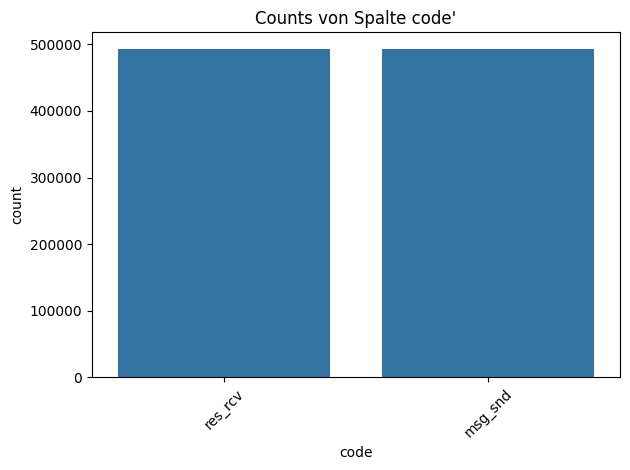

In [130]:
import seaborn as sns
dfc_counts = dfc.groupBy("code").count()
dfc_pd = dfc_counts.toPandas()
sns.barplot(data=dfc_pd, x="code", y="count")
plt.title("Counts von Spalte code'")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [131]:
dfc.filter(col("code") == "msg_snd").groupBy("code").count().show()
dfc.filter(col("code") == "res_rcv").groupBy("code").count().show()

+-------+------+
|   code| count|
+-------+------+
|msg_snd|493429|
+-------+------+



+-------+------+
|   code| count|
+-------+------+
|res_rcv|493382|
+-------+------+



Resultate und "Out-of-scope" Punkte: 

- Eine gute Balance zwischen gesendeten Nachrichten und erhaltene Nachrichten. Nu wenige (47) gehen unter. Der Lasttest ist somit erfolgreich, je nach dem was als Fehlerquote akzeptiert wird. Je nach Wichtigkeit der Nachricht könnte auch eine sehr kleine akzeptierte Fehelrquote zu hoch sein.

#### Überprüfung Spalte client_id

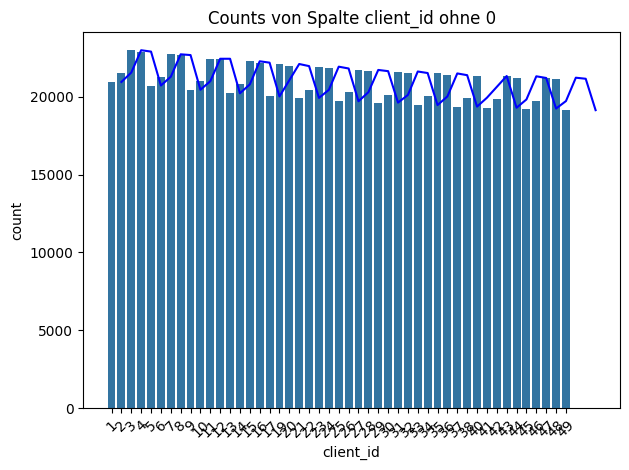

In [132]:
import seaborn as sns
dfc_counts = dfc.groupBy("client_id").count()
dfc_pd = dfc_counts.toPandas().sort_values("client_id", ascending=True)
sns.barplot(data=dfc_pd, x="client_id", y="count")
sns.lineplot(data=dfc_pd, x="client_id", y="count", color="blue")
plt.title("Counts von Spalte client_id ohne 0")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte: 

- Immer vier Clients nehmen stetig an der Anzahl zu, es scheint mit Absicht so gestaltet worden, dies wohl für den Lasttest. Es handelt sich somit hier um ein künstlich erstellte Last, um eben für den Lasttest sehen zu wollen, wie erfolgreich auch mit Peaks umzugehen ist. Denn Peaks sind ein normaler Bestandteil jeglicher Netzwerke und müssen getestet werden.

- Ebenfalls nimmt die Anzahl stetig ab von Client 1 bis Client 49. Auch hier will wohl gesehen werden, wie der Lasttest aussieht, auch bei Abnahme der Anzahl.

- Die beinahe Realität will simuliert werden oder zumindest, was in der Realität vorkommen kann.

#### Überprüfung Spalte loc_ts

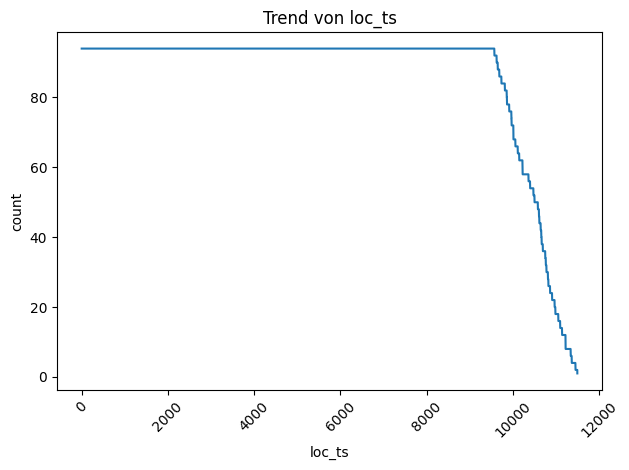

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
dfc_counts = dfc.groupBy("loc_ts").count()
dfc_pd = dfc_counts.toPandas()
sns.lineplot(data=dfc_pd, x="loc_ts", y="count")
plt.title("Trend von loc_ts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte: 

- loc_ts soll ein Lokaler Timestamp des Ereignisses (Laufnummer) sein.

- Es scheint, dass über alle Clients hinweg, die sehr hohen loc_ts weniger oft vorkommen. Hier gibt es weniger Events.

#### Überprüfung Spalte op

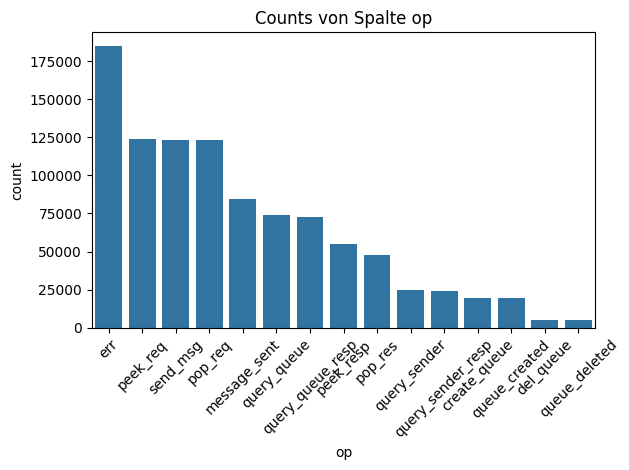

In [134]:
import seaborn as sns
dfc_counts = dfc.groupBy("op").count()
dfc_pd = dfc_counts.toPandas().sort_values("count", ascending=False)
sns.barplot(data=dfc_pd, x="op", y="count")
plt.title("Counts von Spalte op")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Überprüfung von err und err_code zusammen

184715


+---+---+-----+---+------+---+-----+---+---+
| op|  0|    1| 10|    11| 13|   14| 16| 19|
+---+---+-----+---+------+---+-----+---+---+
|err|100|10878| 63|108994| 22|64600| 46| 12|
+---+---+-----+---+------+---+-----+---+---+



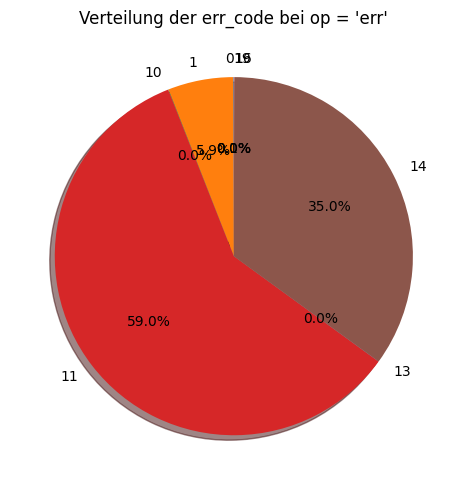

In [135]:
dfc_err = dfc.filter(col("op") == "err")
print(dfc.filter(col("op") == "err").count())

dfc_pivot = (
    dfc_err.groupBy("op")
    .pivot("err_code")
    .count()
    .orderBy("op", ascending=True)
)

dfc_pivot.show()

plt.figure(figsize=(5, 5)) 
dfc_pd = dfc_pivot.toPandas()
dfc_series = dfc_pd.drop(columns=["op"]).iloc[0]
dfc_series.plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
plt.title("Verteilung der err_code bei op = 'err'")
plt.ylabel("")
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte: 

- Mit 59 Prozent ist der Fehler 11 am stärksten vertreten, **queue non-existent**. 
  
- Mit 14 Prozent ist der Fehler 14 vorgekommen **queue empty**.

- Mit 5.9 Prozent ist der Fehler 1 vorgekommen, **SQL error**.

- Mit all den weiteren Fehlern ist der Prozentsatz sehr gering.

- Fehler  **"client non-existent"**, **"sender non-existent"**, **"enrolment fail"** kommen nicht vor, die Clients und der Server laufen also immer oder werden rasch genug wieder hergestellt.

- Von all den Zeilen 986811 und der Anzahl von Fehlern mit 184715 ist die Division ungefähr 0.187. Ungefähr 18.7% sind also Fehler. Das sollte verbessert werden. Wie kommt es zu nicht existierenden Queue oder der leeren Queue?

#### Mehr noch zu den anderen vorkommenden Operationen

Resultate und "Out-of-scope" Punkte: 

- Es macht Sinn, dass die Queue am wenigsten gelöscht wird (del_queue und queue_deleted), da in der Queue mehrere Jobs abgearbeitet werden.

- Jedoch aufgrund den Fehlern queue non-existent und queue empty sollte dies überprüft werden.

- Es macht auch Sinn, dass peek_req nach den Fehlern am häufigsten vorkommt, der Status muss ja überprüft werden. Ebenfalls auch das Versenden der Nachricht und das Entfernen des Element aus der Queue.

#### Überprüfung Spalte err_code

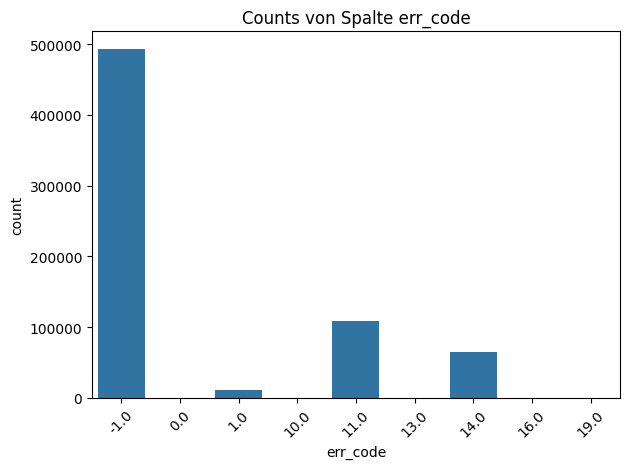

In [136]:
import seaborn as sns
dfc_counts = dfc.groupBy("err_code").count()
dfc_pd = dfc_counts.toPandas().sort_values("count", ascending=False)
sns.barplot(data=dfc_pd, x="err_code", y="count")
plt.title("Counts von Spalte err_code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte: 

- -1 bedeutet dass der Reqeust erfolgreich gewesen ist und kein Fehler vorliegt.

- Erneut wieder die Fehler mit der ID 1, 11 und 14 kommen auch hier vor, diese kommen auch im Piechart vor. Mit der Reihenfolge nach Grösse 11,14,1 und das stimmt.

#### Überprüfung Spalte length

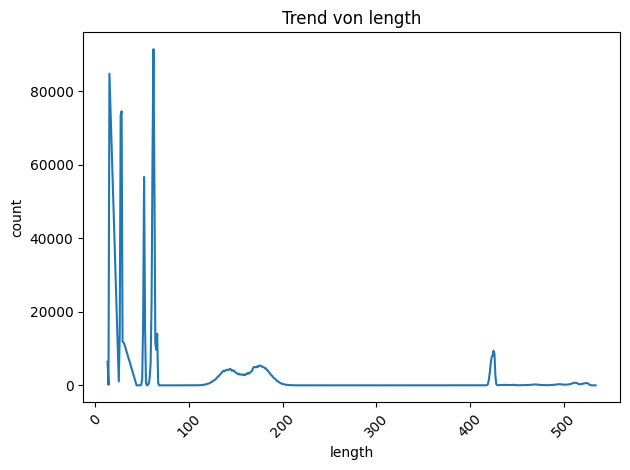

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
dfc_counts = dfc.groupBy("length").count()
dfc_pd = dfc_counts.toPandas()
sns.lineplot(data=dfc_pd, x="length", y="count")
plt.title("Trend von length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte: 

- Sehr lange Nachrichten kommen nicht vor, die meisten sind unter 75.

- Es macht Sinn bei einem Lasttest unterschiedliche Längen zu verwenden. Man will ja auch die Realität simulieren.

- Hat man hier eine Unterhaltung verwendet, deren Anzahl üblicherweise zwischen 0 und 100 liegt? Ist es eine Durchschnittsunterhaltung oder ein Lasttest bei dem es um Real Time Streaming eines Shops geht? Dr Lasttest wird auf was angewendet?

#### Überprüfung Spalte thread_id

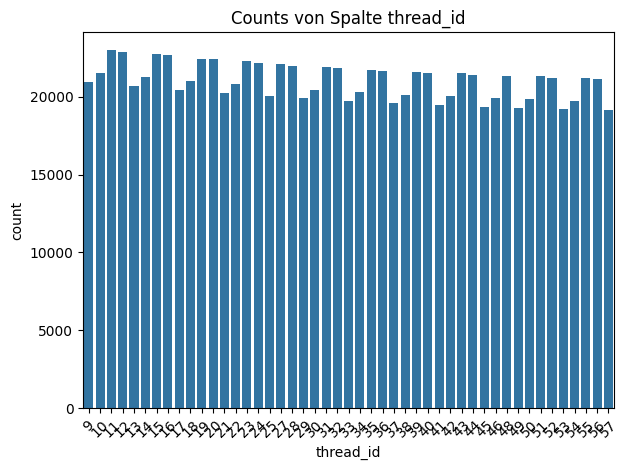

In [138]:
import seaborn as sns
dfc_counts = dfc.groupBy("thread_id").count()
dfc_pd = dfc_counts.toPandas().sort_values("thread_id", ascending=True)
sns.barplot(data=dfc_pd, x="thread_id", y="count")
plt.title("Counts von Spalte thread_id")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Resultate und "Out-of-scope" Punkte **(ähnlich wie bei client_id)**: 

- Immer vier Threads nehmen stetig an der Anzahl zu, es scheint mit Absicht so gestaltet worden. Man will wohl auch die Threads unter erhöhter Last testen, hier am Beispiel der vorkommenden Anzahl.

- Die letzten beiden pro Vierergruppe kommen am häufigsten vor.

- Ebenfalls nimmt die Anzahl stetig ab von Thread 9 bis Thread 57.

- Nach der Beschreibung ist dies nicht relevant.

# Beantwortung der weiteren Fragen

#### **Annahmen treffen**

- Die Reihenfolge in den beiden Dateien sind Anhaltspunkt, um die Request/Response-Paare identifizieren zu können. Dies bedeutet, sollte ein pop_req vorkommen wird der nächst vorkommende pop_resp diesem zugewiesen, dies ist dann ein Request/Response-Paar.
  
- Jedes Request/Response-Paar kommt nur in einem Client vor, dass heisst es kann nicht vorkommen, dass ein Request von Client 1 kommt, der dazugehörige Response aber an Client 13 geht.
  
- loc_ts verwendet ebenfalls ms.

**Wichtig 1**
- Die Anzahl Requests und Responses pro Operation sind nicht immmer gleich hoch. Es gibt somit eine Differenz. Für die Beantwortung der Fragen wird nur die gleiche Anzahl verwendet, somit: Die Anzahl Responses wird für die Anzahl der Paare verwendet. Höchstwahrscheinlich liegt es an den Fehlern. Die Abarbeitung eines Request soll vollständig sein.

**Wichtig 2**
- Die vorkommenden Fehler err werden ignoriert, denn die Abarbeitung eines Request soll vollständig sein.

**Wichtig 3**
- Es kann sein, dass gegen Ende nicht immer eine Minute erreicht werden kann, dies wird erwähnt, wird für die Rechnung weggelassen. Siehe bitte dann die Beispielrechnung, die folgt.

**Wichtig 4**
- Paar query_sender_resp - query_queue_resp wird hier ignoriert, da sonst die erste genannte Annhame nicht funktioniert. Denn  query_queue_resp kommt nach der Beschreibung auch bei query_queue vor. Eine Durchmischung soll verhindert werden.

#### Fehler ignorieren

In [139]:
dfc = dfc[dfc['op'] != 'err']
dfs = dfs[dfs['op'] != 'err']

In [140]:
dfc.filter(col("op") == "err").show()

+---+----+---------+------+------+---+--------+----+---------+
| id|code|client_id|loc_ts|length| op|err_code|time|thread_id|
+---+----+---------+------+------+---+--------+----+---------+
+---+----+---------+------+------+---+--------+----+---------+



In [141]:
dfs.filter(col("op") == "err").show()

+---+----+---------+------+------+---+--------+----+---------+
| id|code|client_id|loc_ts|length| op|err_code|time|thread_id|
+---+----+---------+------+------+---+--------+----+---------+
+---+----+---------+------+------+---+--------+----+---------+



Resultat: 

- err Werte in der Spalte op sind nun entfernt, dies für beide, sowohl Client als auch Server.

#### Request/Response-Paare Unterschiede

Paare identifizieren, Unterschiede festhalten, dies am Beispiel von "create_queue" und "queue_created".

In [142]:
op_pairs = [
    ("create_queue", "queue_created"),
]

ordered_op_list = [op for pair in op_pairs for op in pair]


# Filter
filtered_df = dfc.filter(
    (col("op").isin(ordered_op_list)) &
    col("client_id").isin([str(i) for i in range(1, 50)])
)

# Gruppe mit Pivot
grouped_counts = (
    filtered_df
    .groupBy("client_id", "op")
    .count()
)

pivoted_df = (
    grouped_counts
    .groupBy("client_id")
    .pivot("op", ordered_op_list)
    .sum("count")
    .na.fill(0)
    .orderBy("client_id")
)

# Differenz
diff_col_name = "create_queue_diff"
pivoted_df = pivoted_df.withColumn(
    diff_col_name,
    col("create_queue") - col("queue_created")
)

# Resultat
pivoted_df.show(10, truncate=False)

+---------+------------+-------------+-----------------+
|client_id|create_queue|queue_created|create_queue_diff|
+---------+------------+-------------+-----------------+
|1        |400         |399          |1                |
|2        |402         |398          |4                |
|3        |463         |459          |4                |
|4        |464         |460          |4                |
|5        |416         |416          |0                |
|6        |404         |400          |4                |
|7        |469         |469          |0                |
|8        |447         |444          |3                |
|9        |405         |400          |5                |
|10       |411         |410          |1                |
+---------+------------+-------------+-----------------+
only showing top 10 rows



Resultate und "Out-of-scope" Punkte: 

- Für eine weitere Analyse können die Unterschiede ebenfalls hilfreich sein oder hinterfragt werden. Dies ebenfalls für alle Paare.

## Request/Response-Paare Berechnung der Zeit mit loc_ts am Beispiel von von "create_queue" und "queue_created" und client_id == 1

Vorgehensweise:

- Filter nach client_id == 1
- Am Beispiel von dem Paar op == query_queue und op == query_queue_resp
- Nach loc_ts aufsteigend sortieren
- Window verwenden und als Zeile festhalten
- Zeit und Mittelwert berechnen
- Tabelle und Plot darstellen

Fokus auf loc_ts und op

In [143]:
dfc.filter(col("client_id") == 1).orderBy("loc_ts").select("loc_ts","op").show()
count = dfc.filter(col("client_id") == 1).orderBy("loc_ts").select("loc_ts","op").count()

+------+-----------+
|loc_ts|         op|
+------+-----------+
|     2|query_queue|
|     3|   peek_req|
|     4|   peek_req|
|     5|   peek_req|
|     6|   peek_req|
|     7|   peek_req|
|     8|   peek_req|
|     9|   peek_req|
|    10|   peek_req|
|    11|   peek_req|
|    12|   peek_req|
|    13|query_queue|
|    14|   send_msg|
|    15|    pop_req|
|    16|query_queue|
|    17|    pop_req|
|    18|   peek_req|
|    19|   peek_req|
|    20|query_queue|
|    21|   peek_req|
+------+-----------+
only showing top 20 rows



Inner Join von Request und Response mit Zeitdifferenz

In [144]:
dfc1 = dfc.filter(col("client_id") == 1).orderBy("loc_ts").select("loc_ts","op")
w = Window.orderBy("op")

# Request
ranked_query = dfc1 \
    .filter(col("op") == "query_queue") \
    .withColumn("rn", row_number().over(w))

# Response
ranked_resp = dfc1 \
    .filter(col("op") == "query_queue_resp") \
    .withColumn("rn", row_number().over(w))

# Inner Join
joined_df = ranked_query.alias("q").join(
    ranked_resp.alias("r"),
    on="rn",
    how="inner"
)

# Zeitdifferenz
joined_with_duration = joined_df.withColumn(
    "duration_ms",
    col("r.loc_ts") - col("q.loc_ts")
)

joined_with_duration.show(100)
countrows= joined_with_duration.count()

total_ms = joined_with_duration.agg(
    spark_sum("duration_ms").alias("total_duration")
).collect()[0]["total_duration"]

print(countrows) # Total Zeilen
print(total_ms) # Total Millisekunden

+---+------+-----------+------+----------------+-----------+
| rn|loc_ts|         op|loc_ts|              op|duration_ms|
+---+------+-----------+------+----------------+-----------+
|  1|     2|query_queue|    41|query_queue_resp|         39|
|  2|    13|query_queue|    42|query_queue_resp|         29|
|  3|    16|query_queue|    59|query_queue_resp|         43|
|  4|    20|query_queue|    79|query_queue_resp|         59|
|  5|    30|query_queue|    81|query_queue_resp|         51|
|  6|    34|query_queue|    98|query_queue_resp|         64|
|  7|    35|query_queue|   108|query_queue_resp|         73|
|  8|    38|query_queue|   110|query_queue_resp|         72|
|  9|    41|query_queue|   135|query_queue_resp|         94|
| 10|    42|query_queue|   139|query_queue_resp|         97|
| 11|    51|query_queue|   141|query_queue_resp|         90|
| 12|    59|query_queue|   148|query_queue_resp|         89|
| 13|    79|query_queue|   150|query_queue_resp|         71|
| 14|    81|query_queue|

1544
333552


Summierung von duration_ms bis mindestens eine Minute erreicht wird:<br>

- rn wird dann in flag eingegeben, was die Position der Zeile ist, wo die Minute erreicht wird.
- die Zeit wird in time eingegeben, was auch mehr als eine Minute sein kann, die Minute soll mindestens erreicht werden, also >= 60000
- in minute kommt die Minute, die Anzahl entspricht den vorkommenden ganzen Minute.

Feststellung der Zeilen, Hinzufügen von der Zeile, Zeit in Millisekunden.

In [145]:
rows = joined_with_duration.collect()
counter_ms=0
flag1 = []
time1 = []
minute1 = []

for row in rows:
    counter_ms = counter_ms + row[5]
    if counter_ms >= 60000:
        flag1.append(row[0])
        time1.append(counter_ms)
        minute1.append(1)
        counter_ms=0

Die Differenz zwischen den Zeilen, die eine Minute erreichen. Wird für den Mittelwert verwendet.

In [146]:
difference1 = []
difference1.append(flag1[0])

for i in range(len(flag1) - 1): 
    diff = flag1[i+1] - flag1[i]
    difference1.append(diff)

In [147]:
print(flag1)
print(time1)
print(minute1)
print(difference1)

[444, 718, 935, 1163, 1414]
[60082, 60203, 60132, 60023, 60088]
[1, 1, 1, 1, 1]
[444, 274, 217, 228, 251]


**Wichtig**
Die letzte Minute wird bei Zeile 1414 erreicht, das Ende ist 1544 (countrows). Diese erreicht die Minute nicht. Dies wird in diesem Fall nicht mehr berücksichtig.

Anzahl vorkommende Minuten.

In [148]:
total_ms1 = joined_with_duration.agg(
    spark_sum("duration_ms").alias("total_duration")
).collect()[0]["total_duration"]

In [149]:
print(total_ms1/60000)

5.5592


Mittelwertberechnung, angewendet auf die Minute.

In [150]:
mid_min1 = []
l=0

for i in minute1: 
    a = 1/difference1[l]
    mid_min1.append(a)
    l=l+1

In [151]:
print(mid_min1)

[0.0022522522522522522, 0.0036496350364963502, 0.004608294930875576, 0.0043859649122807015, 0.00398406374501992]


Darstellung Tabelle, zurück nach Pyspark.

In [152]:
data = list(zip(flag1, time1, minute1, difference1,mid_min1))

schema = StructType([
    StructField("flag", IntegerType(), True),
    StructField("time", LongType(), True),
    StructField("minute", IntegerType(), True),
    StructField("difference", IntegerType(), True),
    StructField("mid_min", FloatType(), True),
])

dfc1_ = spark.createDataFrame(data, schema=schema)

dfc1_.show(100)

+----+-----+------+----------+------------+
|flag| time|minute|difference|     mid_min|
+----+-----+------+----------+------------+
| 444|60082|     1|       444|0.0022522523|
| 718|60203|     1|       274| 0.003649635|
| 935|60132|     1|       217| 0.004608295|
|1163|60023|     1|       228| 0.004385965|
|1414|60088|     1|       251| 0.003984064|
+----+-----+------+----------+------------+



Resultate und "Out-of-scope" Punkte: 

- Was bedeuten die nicht kompletten Minuten? Wie fallen diese ins Gewicht insgesamt gesehen?

## Request/Response-Paare Berechnung der Zeit mit loc_ts aller Clients und mit allen Request/Response-Paaren

Vorgehensweise:

- Für jeden Client berechnen.
- Werte berechen und in eine Tabelle darstellen.
- Anschliessend grafisch darstellen.

**Wichtig**<br>
Da es zwei query_queue_resp gibt, wird das Request/Response Paar query_sender_resp - query_queue_resp ignoriert, denn:<br>
Man geht davon aus, dass die bereits vorhandene Reihenfolge ein Request beginnen lässt und die erste aufkommende dazugehörige Response den Request beendet. Mit mehreren query_queue_resp kann dann nicht gesagt werden welches Response zu welchem Request gehört, man will so eine Durchmischung verhindern.<br>
Ebenfalls soll der Client nur Requests schicken, keine Responses:

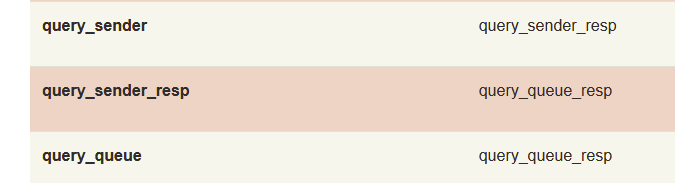

# client1 - client49 clientseitig
Eine einfache Routine, die die Tabellen mit Parquet in das HDFS schreiben:
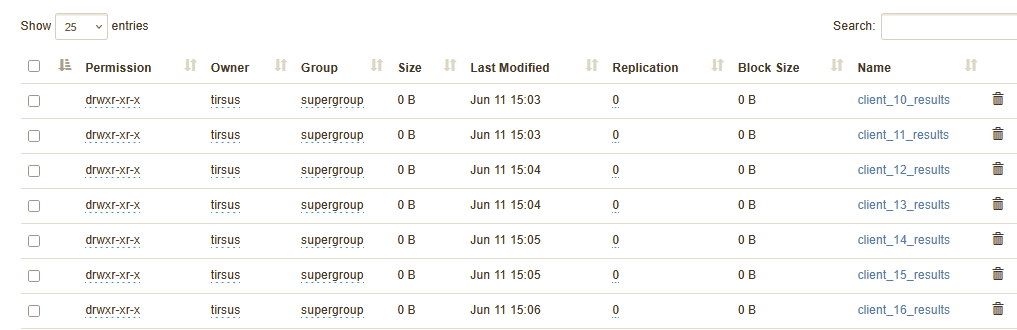
Der Garbage Collector räumt auch gleich auf.

**Ist diese Zelle brereits ausgeführt worden, und die Daten verbleiben üblicherweise im HDFS tmp Ordner, dann muss die Zelle nicht mehr ausgeführt werden.**

In [153]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import gc
import os

# Paare
op_pairs = [
    ("query_queue", "query_queue_resp"),
    ("create_queue", "queue_created"),
    ("del_queue", "queue_deleted"),
    ("send_msg", "message_sent"),
    ("pop_req", "pop_res"),
    ("peek_req", "peek_resp"),
    ("query_sender", "query_sender_resp"),
]

# Window definieren
w = Window.orderBy("op")

# Hadoop FileSystem
hadoop_conf = sc._jsc.hadoopConfiguration()
fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)

# client_id 1 - 49
for client_id in range(1, 50):
    output_path = f"/tmp/client_{client_id}_results/"
    
    # Gibt es bereits die Datei?
    if fs.exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
        print(f"Datei gib es bereits {client_id}.")
        break

    print(f"Processing client_id {client_id}")
    
    # Nach Client filtern
    dfc1 = dfc.filter(F.col("client_id") == client_id) \
              .orderBy("loc_ts") \
              .select("loc_ts", "op")

    for request_op, response_op in op_pairs:
        ranked_query = dfc1 \
            .filter(F.col("op") == request_op) \
            .withColumn("rn", F.row_number().over(w)) \
            .withColumnRenamed("loc_ts", "loc_ts_q") \
            .withColumnRenamed("op", "op_q")

        ranked_resp = dfc1 \
            .filter(F.col("op") == response_op) \
            .withColumn("rn", F.row_number().over(w)) \
            .withColumnRenamed("loc_ts", "loc_ts_r") \
            .withColumnRenamed("op", "op_r")

        joined_df = ranked_query.alias("q").join(
            ranked_resp.alias("r"),
            on="rn",
            how="inner"
        )

        joined_with_duration = joined_df.withColumn(
            "duration_ms",
            F.col("loc_ts_r") - F.col("loc_ts_q")
        )

        # Mit Parquet abspeichern
        joined_with_duration.write.mode("append").parquet(output_path)

        # Memory auflösen
        sc._jvm.java.lang.System.gc()
        gc.collect()


Datei gib es bereits 1.


Zusammenführung in eine Tabelle: Alle Parquet Dateien werden gelesen und in eine Tabelle getan.

In [154]:
# HDF lesen
paths = [f"hdfs://localhost:9000/tmp/client_{i}_results/" for i in range(1, 50)]

# Alle lesen und vereinen
df_all = spark.read.parquet(paths[0])  # Start with the first
for path in paths[1:]:
    df_all = df_all.unionByName(spark.read.parquet(path))  # Ensure schema match

Ausgabe der Datei als Ausschnitt:

In [155]:
df_all.show(100)

+---+--------+--------+--------+------------+-----------+
| rn|loc_ts_q|    op_q|loc_ts_r|        op_r|duration_ms|
+---+--------+--------+--------+------------+-----------+
|  1|      14|send_msg|      28|message_sent|         14|
|  2|      23|send_msg|      40|message_sent|         17|
|  3|      26|send_msg|      52|message_sent|         26|
|  4|      28|send_msg|      53|message_sent|         25|
|  5|      40|send_msg|      55|message_sent|         15|
|  6|      52|send_msg|      56|message_sent|          4|
|  7|      53|send_msg|      64|message_sent|         11|
|  8|      55|send_msg|      72|message_sent|         17|
|  9|      56|send_msg|      73|message_sent|         17|
| 10|      64|send_msg|      77|message_sent|         13|
| 11|      72|send_msg|      91|message_sent|         19|
| 12|      73|send_msg|      93|message_sent|         20|
| 13|      77|send_msg|      99|message_sent|         22|
| 14|      91|send_msg|     102|message_sent|         11|
| 15|      93|

Vorbereitende Berechnungen wie bei dem Client 1 Demo von oben:<br>
Festsellung der Zeilen, Hinzufügen von der Zeile, Zeit in Millisekunden.

In [156]:
rows = df_all.collect()
counter_ms=0
flag2 = []
time2 = []
minute2 = []

for row in rows:
    counter_ms = counter_ms + row[5]
    if counter_ms >= 60000:
        flag2.append(row[0])
        time2.append(counter_ms)
        minute2.append(1)
        counter_ms=0

Die Differenz zwischen den Zeilen, die eine Minute erreichen. Wird für den Mittelwert verwendet.

In [157]:
difference2 = []
difference2.append(flag2[0])
neg = []

for i in range(len(flag2) - 1): 
    diff = flag2[i+1] - flag2[i]
    if diff > 0:
        difference2.append(diff)
    else:
        neg.append(diff)

Anzahl vorkommende Minuten

In [158]:
total_ms2 = df_all.agg(
    spark_sum("duration_ms").alias("total_duration")
).collect()[0]["total_duration"]

In [159]:
print(total_ms2/60000)

7122.891766666667


Mittelwertberechnung

In [160]:
mid_min2 = []

for l in range(len(difference2) - 1): 
    a = 1/difference2[l]
    mid_min2.append(a)

Zusammenfphrung zurück nach Pyspark.

In [161]:
data = list(zip(flag2, time2, minute2, difference2,mid_min2))

schema = StructType([
    StructField("flag", IntegerType(), True),
    StructField("time", LongType(), True),
    StructField("minute", IntegerType(), True),
    StructField("difference", IntegerType(), True),
    StructField("mid_min", FloatType(), True),
])

dfc1_2 = spark.createDataFrame(data, schema=schema)

dfc1_2.show(10)

+----+-----+------+----------+-----------+
|flag| time|minute|difference|    mid_min|
+----+-----+------+----------+-----------+
| 237|60299|     1|       237|0.004219409|
| 356|60154|     1|       119|0.008403362|
| 439|60718|     1|        83|0.012048192|
| 514|60514|     1|        75|0.013333334|
| 582|60436|     1|        68|0.014705882|
| 644|60798|     1|        62|0.016129032|
| 698|60763|     1|        54|0.018518519|
| 744|60421|     1|        46| 0.02173913|
| 787|61177|     1|        43|0.023255814|
| 827|61228|     1|        40|      0.025|
+----+-----+------+----------+-----------+
only showing top 10 rows



Anzahl Zeilen

In [162]:
dfc1_2.count()

6704

Flag entfernen und Spalte id mir Inkrement von 1 hinzufügen:

In [163]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Flag droppen
dfc3 = dfc1_2.drop("flag")

# Inkrementieren
dfc3 = dfc3.withColumn("tmp_id", monotonically_increasing_id())

windowSpec = Window.orderBy("tmp_id")
dfc3 = dfc3.withColumn("id", row_number().over(windowSpec))

dfc3 = dfc3.drop("tmp_id")

cols = ["id"] + [c for c in dfc3.columns if c != "id"]
dfc3 = dfc3.select(cols)

dfc3.show(100)

+---+-----+------+----------+------------+
| id| time|minute|difference|     mid_min|
+---+-----+------+----------+------------+
|  1|60299|     1|       237| 0.004219409|
|  2|60154|     1|       119| 0.008403362|
|  3|60718|     1|        83| 0.012048192|
|  4|60514|     1|        75| 0.013333334|
|  5|60436|     1|        68| 0.014705882|
|  6|60798|     1|        62| 0.016129032|
|  7|60763|     1|        54| 0.018518519|
|  8|60421|     1|        46|  0.02173913|
|  9|61177|     1|        43| 0.023255814|
| 10|61228|     1|        40|       0.025|
| 11|60793|     1|        36| 0.027777778|
| 12|60986|     1|        35| 0.028571429|
| 13|61089|     1|        34| 0.029411765|
| 14|61236|     1|        33| 0.030303031|
| 15|60033|     1|        32|     0.03125|
| 16|60383|     1|        31| 0.032258064|
| 17|61434|     1|        31| 0.032258064|
| 18|60936|     1|        30| 0.033333335|
| 19|61149|     1|        29|  0.03448276|
| 20|61146|     1|        28| 0.035714287|
| 21|62049|

Resultate und "Out-of-scope" Punkte: 

- Was bedeuten die nicht kompletten Minuten? Wie fallen diese ins Gewicht? Ich habe 6970.3957666666665 Minuten aber nur 6560 Zeilen, die einer vollen Minute entsprechen. Die Differenz kommt von allen Paaren, die unvollständig verblieben sind.

## Plots aller Clients

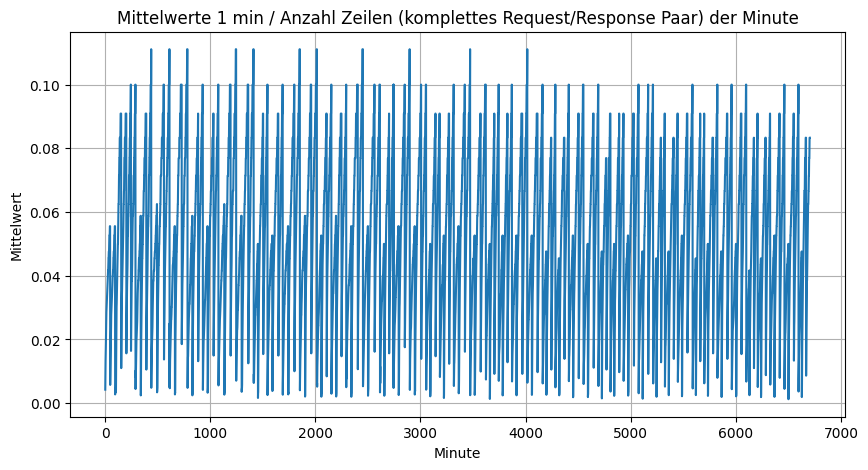

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Group median_ms into chunks of 10
group_size = 1
num_groups = len(mid_min2) // group_size

# Truncate the list to a multiple of 10 to avoid issues
truncated = mid_min2[:num_groups * group_size]

# Reshape and compute group medians
grouped = np.reshape(truncated, (num_groups, group_size))
group_medians = np.median(grouped, axis=1)

# Create X-axis for each group
x_values = range(1, num_groups + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_values, group_medians)
plt.title("Mittelwerte 1 min / Anzahl Zeilen (komplettes Request/Response Paar) der Minute")
plt.xlabel("Minute")
plt.ylabel("Mittelwert")
plt.grid(True)
plt.show()

Zoom in, um Detail erkennen zu können:

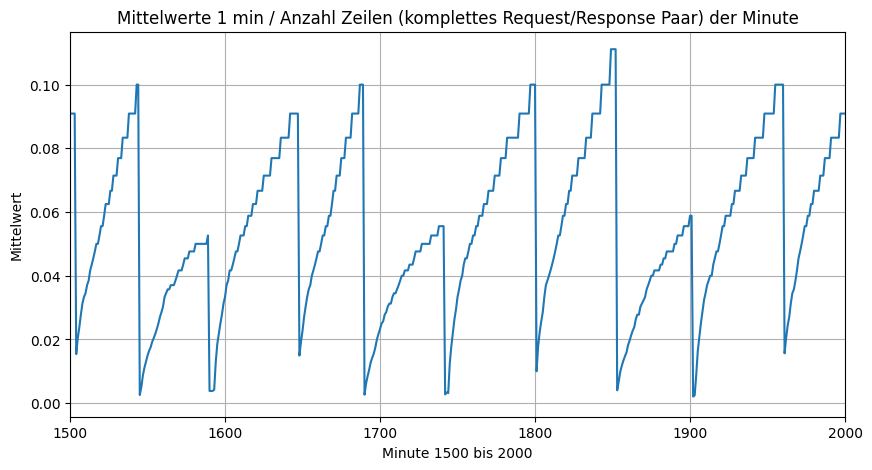

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# Group median_ms into chunks of 10
group_size = 1
num_groups = len(mid_min2) // group_size

# Truncate the list to a multiple of 10 to avoid issues
truncated = mid_min2[:num_groups * group_size]

# Reshape and compute group medians
grouped = np.reshape(truncated, (num_groups, group_size))
group_medians = np.median(grouped, axis=1)

# Create X-axis for each group
x_values = range(1, num_groups + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_values, group_medians)
plt.title("Mittelwerte 1 min / Anzahl Zeilen (komplettes Request/Response Paar) der Minute")
plt.xlabel("Minute 1500 bis 2000")
plt.ylabel("Mittelwert")
plt.xlim(1500, 2000) 
plt.grid(True)
plt.show()

Resultate und "Out-of-scope" Punkte: 

- Hohe Werte bedeuten, dass der Nenner weniger Zeilen (pro erreichte Minute) hat, tiefe Werte bedeuten, dass der Nenner viele Zeilen (pro erreichte Minute) hat. Nimmt also die Anzahl im Nenner zu und der Zähler bleibt bei 1, wird das Resultat immer kleiner.

- Alle tiefen Werte im Plot bedeuten also, dass in jener Minute viele Request/Response Paare vorgekommen sind.

- Alle hohe Werte im Plot bedeuten also, dass in jener Minute wenige Request/Response Paare vorgekommen sind.

## Plots als Beispiel von Client 5

Lesen der Datei:

In [166]:
df_5 = spark.read.parquet("hdfs://localhost:9000/tmp/client_5_results/")

Festsellung der Zeilen, Hinzufügen von der Zeile, Zeit in Millisekunden.

In [167]:
rows = df_5.collect()
counter_ms=0
flag3 = []
time3 = []
minute3 = []

for row in rows:
    counter_ms = counter_ms + row[5]
    if counter_ms >= 60000:
        flag3.append(row[0])
        time3.append(counter_ms)
        minute3.append(1)
        counter_ms=0

Die Differenz zwischen den Zeilen, die eine Minute erreichen. Wird für den Mittelwert verwendet.

In [168]:
difference3 = []
difference3.append(flag3[0])
neg = []

for i in range(len(flag3) - 1): 
    diff = flag3[i+1] - flag3[i]
    if diff > 0:
        difference3.append(diff)
    else:
        neg.append(diff)

Total vorkommende Minute

In [169]:
total_ms3 = df_5.select(sum("duration_ms"))

In [170]:
total_ms3 = df_5.agg(
    spark_sum("duration_ms").alias("total_duration")
).collect()[0]["total_duration"]

In [171]:
print(total_ms3/60000)

154.31861666666666


Mittelwertberechnung

In [172]:
mid_min3 = []

for l in range(len(difference3) - 1): 
    a = 1/difference3[l]
    mid_min3.append(a)

Zusammenführung in eine Pyspark Tabelle:

In [173]:
data = list(zip(flag3, time3, minute3, difference3,mid_min3))

schema = StructType([
    StructField("flag", IntegerType(), True),
    StructField("time", LongType(), True),
    StructField("minute", IntegerType(), True),
    StructField("difference", IntegerType(), True),
    StructField("mid_min", FloatType(), True),
])

dfc1_5 = spark.createDataFrame(data, schema=schema)

dfc1_5.show(10)

+----+-----+------+----------+-----------+
|flag| time|minute|difference|    mid_min|
+----+-----+------+----------+-----------+
| 250|60089|     1|       250|      0.004|
| 362|60297|     1|       112|0.008928572|
| 438|60734|     1|        76|0.013157895|
| 507|60453|     1|        69|0.014492754|
| 574|60502|     1|        67|0.014925373|
| 632|60076|     1|        58| 0.01724138|
| 686|60483|     1|        54|0.018518519|
| 737|60580|     1|        51|0.019607844|
| 784|60883|     1|        47|0.021276595|
| 826|60580|     1|        42|0.023809524|
+----+-----+------+----------+-----------+
only showing top 10 rows



Anazhl vorkommender Zeilen:

In [174]:
dfc1_5.count()

145

Hinzufügen der Spalte id:

In [175]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Falg droppen
dfc4 = dfc1_5.drop("flag")

# Inkrementieren
dfc4 = dfc4.withColumn("tmp_id", monotonically_increasing_id())

windowSpec = Window.orderBy("tmp_id")
dfc4 = dfc4.withColumn("id", row_number().over(windowSpec))

dfc4 = dfc4.drop("tmp_id")

cols = ["id"] + [c for c in dfc4.columns if c != "id"]
dfc4 = dfc4.select(cols)

dfc4.show(100)

+---+-----+------+----------+-----------+
| id| time|minute|difference|    mid_min|
+---+-----+------+----------+-----------+
|  1|60089|     1|       250|      0.004|
|  2|60297|     1|       112|0.008928572|
|  3|60734|     1|        76|0.013157895|
|  4|60453|     1|        69|0.014492754|
|  5|60502|     1|        67|0.014925373|
|  6|60076|     1|        58| 0.01724138|
|  7|60483|     1|        54|0.018518519|
|  8|60580|     1|        51|0.019607844|
|  9|60883|     1|        47|0.021276595|
| 10|60580|     1|        42|0.023809524|
| 11|60089|     1|        39|0.025641026|
| 12|60848|     1|        38| 0.02631579|
| 13|61457|     1|        37|0.027027028|
| 14|60817|     1|        36|0.027777778|
| 15|61120|     1|        35|0.028571429|
| 16|61548|     1|        34|0.029411765|
| 17|60386|     1|        32|    0.03125|
| 18|61076|     1|        32|    0.03125|
| 19|61340|     1|        32|    0.03125|
| 20|61713|     1|        32|    0.03125|
| 21|61696|     1|        31|0.032

## Plots des Client 5

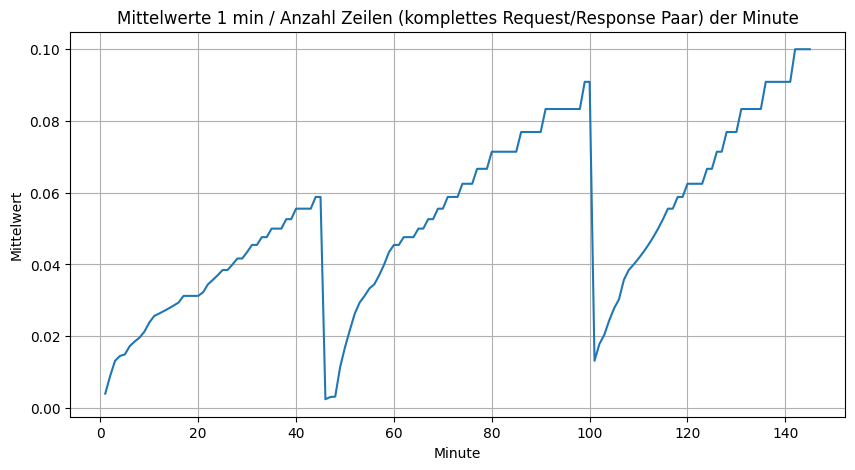

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# Group median_ms into chunks of 10
group_size = 1
num_groups = len(mid_min3) // group_size

# Truncate the list to a multiple of 10 to avoid issues
truncated = mid_min3[:num_groups * group_size]

# Reshape and compute group medians
grouped = np.reshape(truncated, (num_groups, group_size))
group_medians = np.median(grouped, axis=1)

# Create X-axis for each group
x_values = range(1, num_groups + 1)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.plot(x_values, group_medians)
plt.title("Mittelwerte 1 min / Anzahl Zeilen (komplettes Request/Response Paar) der Minute")
plt.xlabel("Minute")
plt.ylabel("Mittelwert")
plt.grid(True)
plt.show()

Resultate und "Out-of-scope" Punkte: 
- Die tiefen Werte bedeuten, dass in jener Minute sehr viele Requests/Response Paare vorgekommen sind.
  
- Die hohen Werte bedeuten, dass in jener Minute wenige Requests/Response Paare vorgekommen sind.

- Die Anzahl Requests/Response Paare nimmt also mit der Zeit ab und nimmst bei den Senken stark zu. Dann wiederholt sich dies.

- Alle Clients untereinander vergleichen wird hier nicht versucht.

# client1 - client49 serverseitig

Eine einfache Routine, die die Tabellen mit Parquet in das HDFS schreiben:

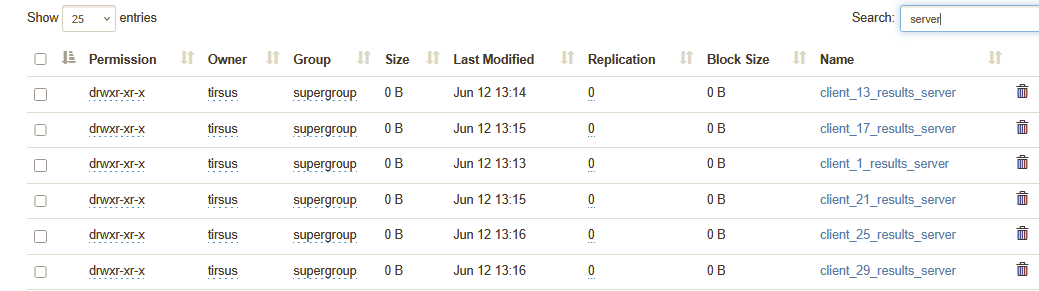

Vorgehensweise:

- Filterung des Dataframe cfs: code soll nur haben msg_arr, res_snd
  
- Erstellung der Dateien mit Parquet auf HDFS wie bei dem Client (mit Client Abstand von 4)
  
- Tabelle berechnen und darstellen
  
- Plots darstellen

In [177]:
dfse = dfs[dfs['code'].isin(['msg_arr', 'res_snd'])]

**Ist diese Zelle brereits ausgeführt worden, und die Daten verbleiben üblicherweise im HDFS tmp Ordner, dann muss die Zelle nicht mehr ausgeführt werden.**

In [178]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import gc

# Paare
op_pairs = [
    ("query_queue", "query_queue_resp"),
    ("create_queue", "queue_created"),
    ("del_queue", "queue_deleted"),
    ("send_msg", "message_sent"),
    ("pop_req", "pop_res"),
    ("peek_req", "peek_resp"),
    ("query_sender", "query_sender_resp"),
]

# Window definieren
w = Window.orderBy("op")

# Hadoop FileSystem
hadoop_conf = sc._jsc.hadoopConfiguration()
fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)

# client_id von 1 to 49 (4 Differenz)
for client_id in range(1, 50, 4):
    output_path = f"/tmp/client_{client_id}_results_server/"
    
    # Check Datei
    if fs.exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
        print(f"Datei gibt es bereits {client_id}.")
        break

    print(f"Processing client_id {client_id}")
    
    # Filter nach Client
    dfse1 = dfse.filter(F.col("client_id") == client_id) \
                .orderBy("loc_ts") \
                .select("loc_ts", "op")

    for request_op, response_op in op_pairs:
        ranked_query = dfse1 \
            .filter(F.col("op") == request_op) \
            .withColumn("rn", F.row_number().over(w)) \
            .withColumnRenamed("loc_ts", "loc_ts_q") \
            .withColumnRenamed("op", "op_q")

        ranked_resp = dfse1 \
            .filter(F.col("op") == response_op) \
            .withColumn("rn", F.row_number().over(w)) \
            .withColumnRenamed("loc_ts", "loc_ts_r") \
            .withColumnRenamed("op", "op_r")

        joined_df = ranked_query.alias("q").join(
            ranked_resp.alias("r"),
            on="rn",
            how="inner"
        )

        joined_with_duration = joined_df.withColumn(
            "duration_ms",
            F.col("loc_ts_r") - F.col("loc_ts_q")
        )

        # Datei beschreiben
        joined_with_duration.write.mode("append").parquet(output_path)

        # Memory leeren
        sc._jvm.java.lang.System.gc()
        gc.collect()


Datei gibt es bereits 1.


Zusammenführung in eine Tabelle für den Server: Alle Parquet Dateien werden gelesen und in eine Tabelle getan.

In [179]:
# Liste aller Dateien
paths = [f"hdfs://localhost:9000/tmp/client_{i}_results_server/" for i in range(1, 50, 4)]

# Vereinen
df_all_s = spark.read.parquet(paths[0])  # Start with the first
for path in paths[1:]:
    df_all_s = df_all_s.unionByName(spark.read.parquet(path))  # Ensure schema match

In [180]:
df_all_s.show(10)

+---+--------+--------+--------+------------+-----------+
| rn|loc_ts_q|    op_q|loc_ts_r|        op_r|duration_ms|
+---+--------+--------+--------+------------+-----------+
|  1|      28|send_msg|      28|message_sent|          0|
|  2|      40|send_msg|      40|message_sent|          0|
|  3|      52|send_msg|      52|message_sent|          0|
|  4|      53|send_msg|      53|message_sent|          0|
|  5|      55|send_msg|      55|message_sent|          0|
|  6|      56|send_msg|      56|message_sent|          0|
|  7|      64|send_msg|      64|message_sent|          0|
|  8|      72|send_msg|      72|message_sent|          0|
|  9|      73|send_msg|      73|message_sent|          0|
| 10|      77|send_msg|      77|message_sent|          0|
+---+--------+--------+--------+------------+-----------+
only showing top 10 rows



Festsellung der Zeilen, Hinzufügen von der Zeile, Zeit in Millisekunden.

In [181]:
rows = df_all_s.collect()
counter_ms=0
flag4 = []
time4 = []
minute4 = []

for row in rows:
    counter_ms = counter_ms + row[5]
    if counter_ms >= 60000:
        flag4.append(row[0])
        time4.append(counter_ms)
        minute4.append(1)
        counter_ms=0

Die Differenz zwischen den Zeilen, die eine Minute erreichen. Wird für den Mittelwert verwendet.

In [182]:
difference4 = []
difference4.append(flag4[0])
neg = []

for i in range(len(flag4) - 1): 
    diff = flag4[i+1] - flag4[i]
    if diff > 0:
        difference4.append(diff)
    else:
        neg.append(diff)

Mittelwertberechnung

In [183]:
mid_min4 = []

for l in range(len(difference4) - 1): 
    a = 1/difference4[l]
    mid_min4.append(a)

Total der vokormmenden Minuten

In [184]:
total_ms4 = df_all_s.agg(
    spark_sum("duration_ms").alias("total_duration")
).collect()[0]["total_duration"]

In [185]:
print(total_ms4/60000)

3908.5683


Zurück nach Pyspark

In [186]:
data = list(zip(flag4, time4, minute4, difference4,mid_min4))

schema = StructType([
    StructField("flag", IntegerType(), True),
    StructField("time", LongType(), True),
    StructField("minute", IntegerType(), True),
    StructField("difference", IntegerType(), True),
    StructField("mid_min", FloatType(), True),
])

df_all_s_t = spark.createDataFrame(data, schema=schema)

df_all_s_t.show(10)

+----+-----+------+----------+------------+
|flag| time|minute|difference|     mid_min|
+----+-----+------+----------+------------+
| 244|60405|     1|       244|0.0040983604|
| 363|60124|     1|       119| 0.008403362|
| 445|60185|     1|        82|0.0121951215|
| 520|60168|     1|        75| 0.013333334|
| 589|60863|     1|        69| 0.014492754|
| 651|60880|     1|        62| 0.016129032|
| 704|60371|     1|        53| 0.018867925|
| 750|60800|     1|        46|  0.02173913|
| 793|61250|     1|        43| 0.023255814|
| 832|60111|     1|        39| 0.025641026|
+----+-----+------+----------+------------+
only showing top 10 rows



ID hinzufügen, flag fallen lassen

In [187]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Flag droppen
dfc5 = df_all_s_t.drop("flag")

# Inkrementieren
dfc5 = dfc5.withColumn("tmp_id", monotonically_increasing_id())

windowSpec = Window.orderBy("tmp_id")
dfc5 = dfc5.withColumn("id", row_number().over(windowSpec))

dfc5 = dfc5.drop("tmp_id")

cols = ["id"] + [c for c in dfc5.columns if c != "id"]
dfc5 = dfc5.select(cols)

dfc5.show(100)

+---+-----+------+----------+------------+
| id| time|minute|difference|     mid_min|
+---+-----+------+----------+------------+
|  1|60405|     1|       244|0.0040983604|
|  2|60124|     1|       119| 0.008403362|
|  3|60185|     1|        82|0.0121951215|
|  4|60168|     1|        75| 0.013333334|
|  5|60863|     1|        69| 0.014492754|
|  6|60880|     1|        62| 0.016129032|
|  7|60371|     1|        53| 0.018867925|
|  8|60800|     1|        46|  0.02173913|
|  9|61250|     1|        43| 0.023255814|
| 10|60111|     1|        39| 0.025641026|
| 11|60763|     1|        36| 0.027777778|
| 12|60953|     1|        35| 0.028571429|
| 13|60927|     1|        34| 0.029411765|
| 14|60735|     1|        33| 0.030303031|
| 15|60096|     1|        32|     0.03125|
| 16|61900|     1|        32|     0.03125|
| 17|61357|     1|        31| 0.032258064|
| 18|60985|     1|        30| 0.033333335|
| 19|61205|     1|        29|  0.03448276|
| 20|61079|     1|        28| 0.035714287|
| 21|61893|

## Plots serverseitig

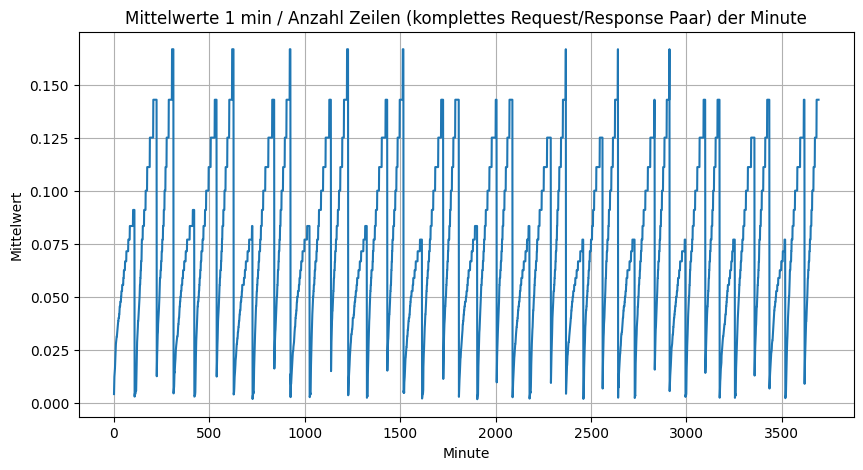

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Group median_ms into chunks of 10
group_size = 1
num_groups = len(mid_min4) // group_size

# Truncate the list to a multiple of 10 to avoid issues
truncated = mid_min4[:num_groups * group_size]

# Reshape and compute group medians
grouped = np.reshape(truncated, (num_groups, group_size))
group_medians = np.median(grouped, axis=1)

# Create X-axis for each group
x_values = range(1, num_groups + 1)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.plot(x_values, group_medians)
plt.title("Mittelwerte 1 min / Anzahl Zeilen (komplettes Request/Response Paar) der Minute")
plt.xlabel("Minute")
plt.ylabel("Mittelwert")
plt.grid(True)
plt.show()

Zoom Plot zwischen 0 und 500

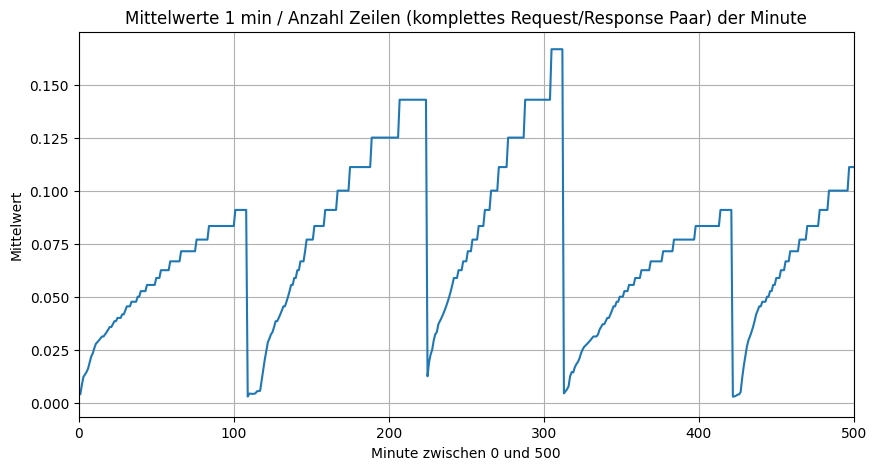

In [189]:
import numpy as np
import matplotlib.pyplot as plt

# Group median_ms into chunks of 10
group_size = 1
num_groups = len(mid_min4) // group_size

# Truncate the list to a multiple of 10 to avoid issues
truncated = mid_min4[:num_groups * group_size]

# Reshape and compute group medians
grouped = np.reshape(truncated, (num_groups, group_size))
group_medians = np.median(grouped, axis=1)

# Create X-axis for each group
x_values = range(1, num_groups + 1)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.plot(x_values, group_medians)
plt.title("Mittelwerte 1 min / Anzahl Zeilen (komplettes Request/Response Paar) der Minute")
plt.xlabel("Minute zwischen 0 und 500")
plt.ylabel("Mittelwert")
plt.grid(True)
plt.xlim(0, 500) 
plt.show()

Resultate und "Out-of-scope-Thema":

- Die Plots sind den vorangegangenen Plots ähnlich (clientseitig).
  
- Es kommen weniger Minuten vor, weil auch die Anzahl clients, niedriger ist (von 1 bis 49 mit einem Abstand von 4)

- Das typische Zackenverhalten kommt auch hier vor, es sind also die gleichen Aussagen.

# Timestamp-Server

**Wichtig** <br>
1. Es kommt mit ts_rcvd ein Timestamp, danach folgen die Messages<br>
2. Diese kommen in die Queue<br>
3. Wird von der Queue genommen<br>
4. Die Transaktion wird ausgeführt<br>
5. Antwort wird dem Client gesendet<br>
6. Zwischen den ts_rcvd gibt es viele dieser Nachrichten.
7. Die Client IDs können nun verschieden sein, denn diese kommen verschieden in die Queue.

**Es wir hier nicht die Dauer des Timestamp angesehen (Differenz ts_rcvd und allen danach vorkommenden msg_arr), sondern die Antwortzeit, die ts_rcvd (Timestamp erhalten) entspricht.**

**Anname:**
Ich kann hier nach loc_ts sortieren, das es ein Server ist und viele Clients Nachrichten an den einen Server senden.

**Annahme:**
Die Clients ID kann die in die Queue können verschieden sein, denn der Server nimmt viele Nachrichten verschiedener Clients entgegen.

Dataframe holen, alle ts_rcvd bestimmen:

In [190]:
dftimes = dfs

In [191]:
df_timestamps =dftimes.filter(col("code") == "ts_rcvd").orderBy(col("loc_ts"))

In [192]:
df_timestamps.show()

+-----+-------+---------+------+------+--------+--------+----------+---------+
|   id|   code|client_id|loc_ts|length|      op|err_code|      time|thread_id|
+-----+-------+---------+------+------+--------+--------+----------+---------+
| 1996|ts_rcvd|        9|    14|   166|send_msg|      -1|1.41425E12|       16|
|  617|ts_rcvd|        5|    14|   178|send_msg|      -1|1.41425E12|       15|
| 3733|ts_rcvd|       13|    14|   157|send_msg|      -1|1.41425E12|       17|
|12455|ts_rcvd|       29|    14|   161|send_msg|      -1|1.41425E12|       21|
|14809|ts_rcvd|       33|    14|   191|send_msg|      -1|1.41425E12|       22|
|16980|ts_rcvd|       37|    14|   182|send_msg|      -1|1.41425E12|       23|
| 3753|ts_rcvd|       13|    15|   173|send_msg|      -1|1.41425E12|       17|
|10398|ts_rcvd|       25|    15|   176|send_msg|      -1|1.41425E12|       20|
|17031|ts_rcvd|       37|    15|   174|send_msg|      -1|1.41425E12|       23|
| 6012|ts_rcvd|       17|    16|   154|send_msg|    

Plot der ts_rvd über die ganze Zeit hinweg:

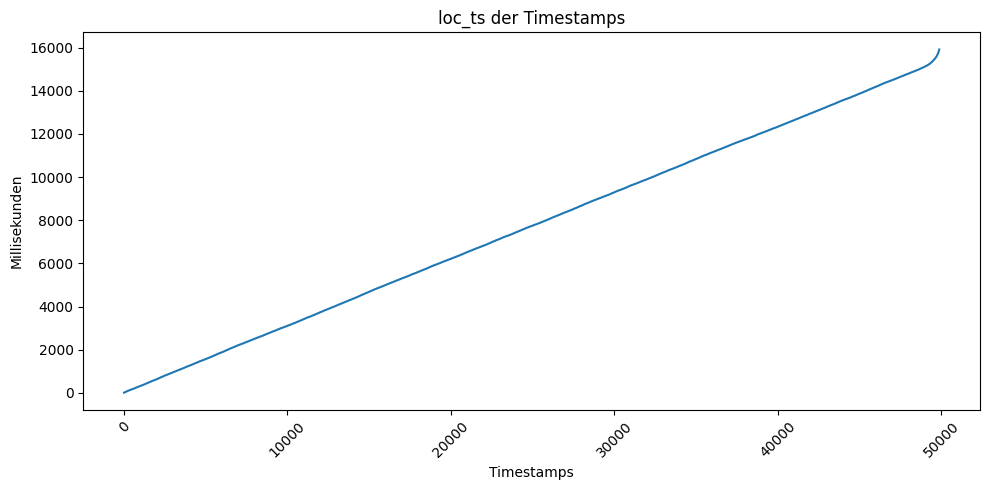

In [193]:
pdf = df_timestamps.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(range(len(pdf)), pdf['loc_ts']) 
plt.xlabel("Timestamps")
plt.ylabel("Millisekunden")
plt.title("loc_ts der Timestamps")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [194]:
pdf["code"].count()

49880

Resultate:

- Es gibt 49880 Timestamps die vorkommen.

- Die Anzahl nimmt stetig zu.

- Am Ende gibt es eine leichte Veränderung.

Differenz zwischen den Timestamps (pro loc_ts können mehrere Timestamps vorkommen) und die Zeitdifferenz zwischen den loc_ts:

In [195]:
ts_counts = pdf.groupby("loc_ts").size().reset_index(name="ts_rcvd_count")
ts_counts["loc_ts_diff"] = ts_counts["loc_ts"].diff().fillna(0).astype(int)
print(ts_counts)

       loc_ts  ts_rcvd_count  loc_ts_diff
0          14              6            0
1          15              3            1
2          16              4            1
3          17              2            1
4          18              2            1
...       ...            ...          ...
15259   15897              1            4
15260   15900              1            3
15261   15901              1            1
15262   15910              1            9
15263   15914              1            4

[15264 rows x 3 columns]


Barplot der loc_ts und der Zeitdifferenz zwischen den loc_ts:

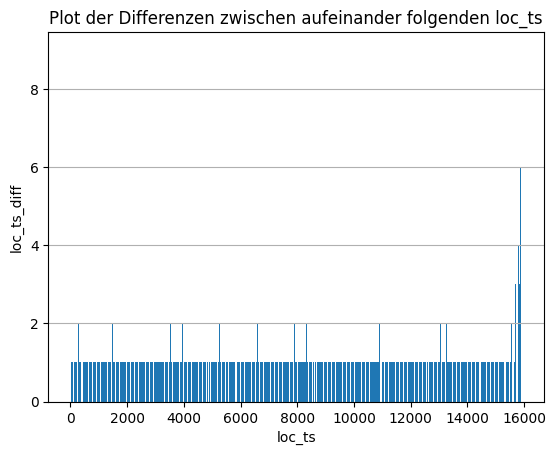

In [196]:
plt.bar(ts_counts["loc_ts"], ts_counts["loc_ts_diff"])

plt.xlabel("loc_ts")
plt.ylabel("loc_ts_diff")
plt.title("Plot der Differenzen zwischen aufeinander folgenden loc_ts")

plt.grid(True, axis='y')

Resultate und "Out-of-Scope" Thema:

- Die Differenz ist meistens bei 1, mit wenigen Peaks bei 2.

- Gegen Ende nimmt die Differenz zu. Was bedeuten die Peaks und die Zunahme gegen Ende hin?

Plot der loc_ts und die darin vorkommenden Timestamps:

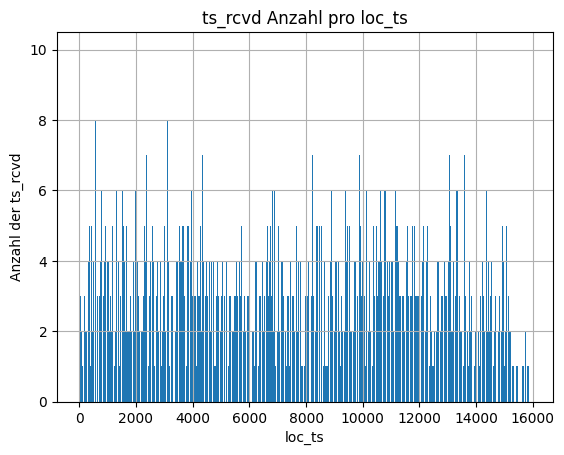

In [197]:
plt.bar(ts_counts["loc_ts"], ts_counts["ts_rcvd_count"])
plt.xlabel("loc_ts")
plt.ylabel("Anzahl der ts_rcvd")
plt.title("ts_rcvd Anzahl pro loc_ts")
plt.grid(True)
plt.show()

Resultate:

- Die Maximum Anzahl von erhaltenen Timestamps pro loc_ts ist 8. Bedeutet dies, dass nun 8 verschiedene Timestamp geholt weden, oder derselbe Timestamp 8 verschiedenen Clients vergeben wird?

Dasselbe nochmals zwischen 0 und 1000:

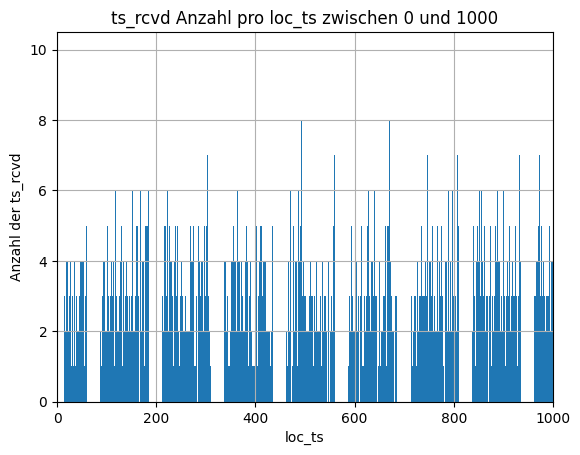

In [198]:
plt.bar(ts_counts["loc_ts"], ts_counts["ts_rcvd_count"])
plt.xlabel("loc_ts")
plt.ylabel("Anzahl der ts_rcvd")
plt.title("ts_rcvd Anzahl pro loc_ts zwischen 0 und 1000")
plt.xlim(0,1000)
plt.grid(True)
plt.show()

Resultate und "Out-of-scope":

- Hier erkennt man gut die Dichte, die Anzahl Timestamps pro gleicher Zeit sind 1 bis 2.

- Dazwischen gibt es auch keine Timestamps.

## Überprüfung der Aussage anhand loc_ts == 8456

Mit dem loc_ts == 8456 soll nun näher betrachtet werden, ob die Aussage stimmen könnte.

In [199]:
dftimes2 = dfs.filter((col("loc_ts") == 8456) & (col("code") == "ts_rcvd"))

In [200]:
dftimes2_pd = dftimes2.toPandas()
dftimes2_pd.style.map(lambda v: 'background-color: yellow' if v == 'ts_rcvd' else '')

,id,code,client_id,loc_ts,length,op,err_code,time,thread_id
0,547054,ts_rcvd,5,8456,186,send_msg,-1,1414250000000.000000,15
1,574438,ts_rcvd,21,8456,160,send_msg,-1,1414250000000.000000,19
2,589918,ts_rcvd,33,8456,174,send_msg,-1,1414250000000.000000,22
3,595768,ts_rcvd,41,8456,203,send_msg,-1,1414250000000.000000,24
4,600999,ts_rcvd,49,8456,164,send_msg,-1,1414250000000.000000,26


Resultate und "Out-of-scope":

- Es scheint so, dass der Timestamp einmal vom Timestamp-Server geholt wird, und dann anschliessend verschiedenen Clients gegeben wird. Da es multithreaded ist, macht dies Sinn.

- Es würde weniger Sinn machen, dass es sich hierbei um 5 verschieden Timestamp halten würde, da die Antwort des Timestamp-Serve hier unter 1 Millisekunde liegen müsste, was eher unwahrscheinlich scheint.

# Interpretation des Timestamp-Server Verhalten gegenüber den anderen Systemkomponenten

- Clients senden Responses und warten auf Requests.

- Server nimmt Request entgegen, holt den Timestamp, setzt dies in die Queue, dann folgt die Transaktion, sendet die Response an den Client zurück.

- Timestamp-Server wartet auf das "Holen eines Timestamp" von dem Server. Dies scheint die einzige "Aktivität" zu sein.

- Der Timestamp-Server scheint beständiger im Millieskunden Takt zu reagieren (sehe oben Plot der Differenzen zwischen aufeinanderfolgenden loc_ts), mit wenigen Peaks und gegen Ende hin gibt es eine Zunahme. Weder Client noch Server scheinen so beständig zu sein. Siehe auch Tabellen mit duration_ms.

# Schwächen der Analyse

- Fehler werden ignoriert
  
- Fehlende Respones zu Request werden ignoriert, wie hat dies auf die Gesamtrechung Einfluss?

- Aufgrund des JVM habe ich mich erst danach für Parquet und Garbage Collector entschieden, diese Überlegung hätte ich bereits zu Anbeginn durchdenken müssen.

- Man hätte wohl auch sparsamer und gezielter vorgehen können, in dem man alles in eine Datei aggregiert und auf HDFS speichert. Auch für die Darstellungne könnte man eine Tabelle verwenden, in der sowohl clientseitig wie auch serverseitig Einträge vorkommen.
  
- **Besser** Man hätte die Request/Response Paare mit einer ID vergeben können, um dann alle Paare in einer Datei zu speichern, damit man die Paare identifizieren könnte.

- **Besser**: Für die Identifizierung der Anzahl Zeilen pro Minute habe ich hier mit Python gearbeitet, hätte man auch mit Pyspark lösen können.
  
- **Ev**: Gäbe es eine Use Case, bei dem man die separaten Auszüge wieder verwenden könnte?

- **Jedoch**: Es ist nicht Bestandteil der Aufgabe gezielt und sparsam zu programmieren.

## Hinweise und Quellenverzeichnis

Wo hat ChatGPT geholfen?

- Schleife durch alle Clients mit dem Garbage Collector: Wie ging das mit dem Garbage Collector?
  
- Lesen aller Parquet Dateien aus dem HDFS Verzeichnis: Wie ging das nochmals?
  
- Hinzufügen der ID zur Tabelle, inkrementiert mit 1: Wie ging das nochmals?

- Lambda Funktion: Wie ging das nochmals?

Idee mit Window:
- [Tanimura] Chapter 3: Time Series Analysis